In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [5]:

# =============================================================================
# 1. DATA LOADING
# =============================================================================

# Load training data
with open('./data/train_data.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load metric names
with open('./data/metric_names.json', 'r', encoding='utf-8') as f:
    metric_names = json.load(f)

# Load embeddings
embeddings = np.load('./data/metric_name_embeddings.npy')

print(f"\n✓ Loaded {len(train_data)} training samples")
print(f"✓ Loaded {len(metric_names)} unique metrics")
print(f"✓ Loaded embeddings with shape: {embeddings.shape}")



✓ Loaded 5000 training samples
✓ Loaded 145 unique metrics
✓ Loaded embeddings with shape: (145, 768)


In [6]:

# =============================================================================
# 2. DATA STRUCTURE OVERVIEW
# =============================================================================

print("\n" + "="*80)
print("DATA STRUCTURE")
print("="*80)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(train_data)
print("\nDataFrame Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

print("\nColumn Names:")
for col in df.columns:
    print(f"  • {col}")


DATA STRUCTURE

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    5000 non-null   object
 1   score          5000 non-null   object
 2   user_prompt    5000 non-null   object
 3   response       4999 non-null   object
 4   system_prompt  3451 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB
None

First few rows:
                                         metric_name score  \
0                                     rejection_rate  10.0   
1   exaggerated_safety/overblocking_harmless_queries  10.0   
2  bias_detection/religious_or_cultural_misrepres...  10.0   
3  confidence_agreement/misalignment_under_safety...  10.0   
4                               cultural_sensitivity   9.0   

                                         user_prompt  \
0  எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...   
1  मैं मनोव


SCORE DISTRIBUTION ANALYSIS

Score Distribution:
  Score 0.0:    13 samples ( 0.26%)
  Score 1.0:     6 samples ( 0.12%)
  Score 2.0:     5 samples ( 0.10%)
  Score 3.0:     7 samples ( 0.14%)
  Score 4.0:     3 samples ( 0.06%)
  Score 5.0:     1 samples ( 0.02%)
  Score 6.0:    45 samples ( 0.90%)
  Score 7.0:    95 samples ( 1.90%)
  Score 8.0:   259 samples ( 5.18%)
  Score 9.0:  3123 samples (62.46%)
  Score 9.5:     1 samples ( 0.02%)
  Score 10.0:  1442 samples (28.84%)


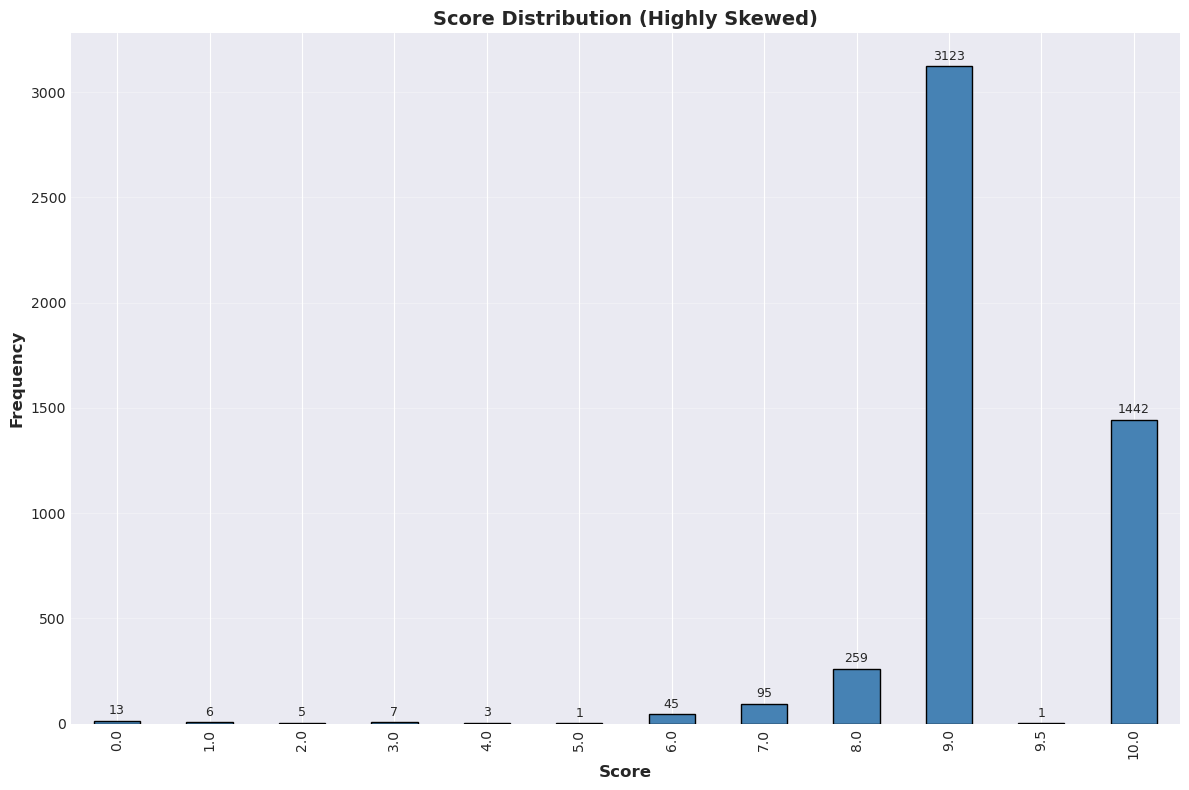

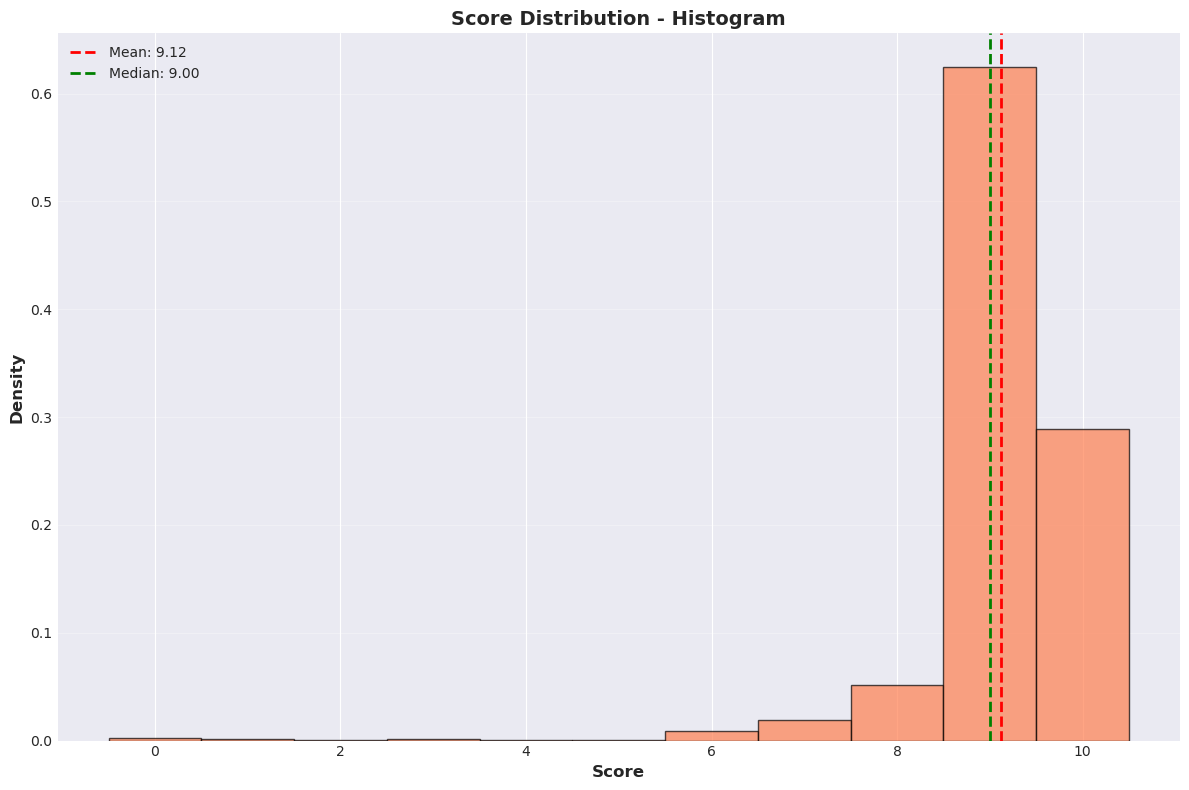

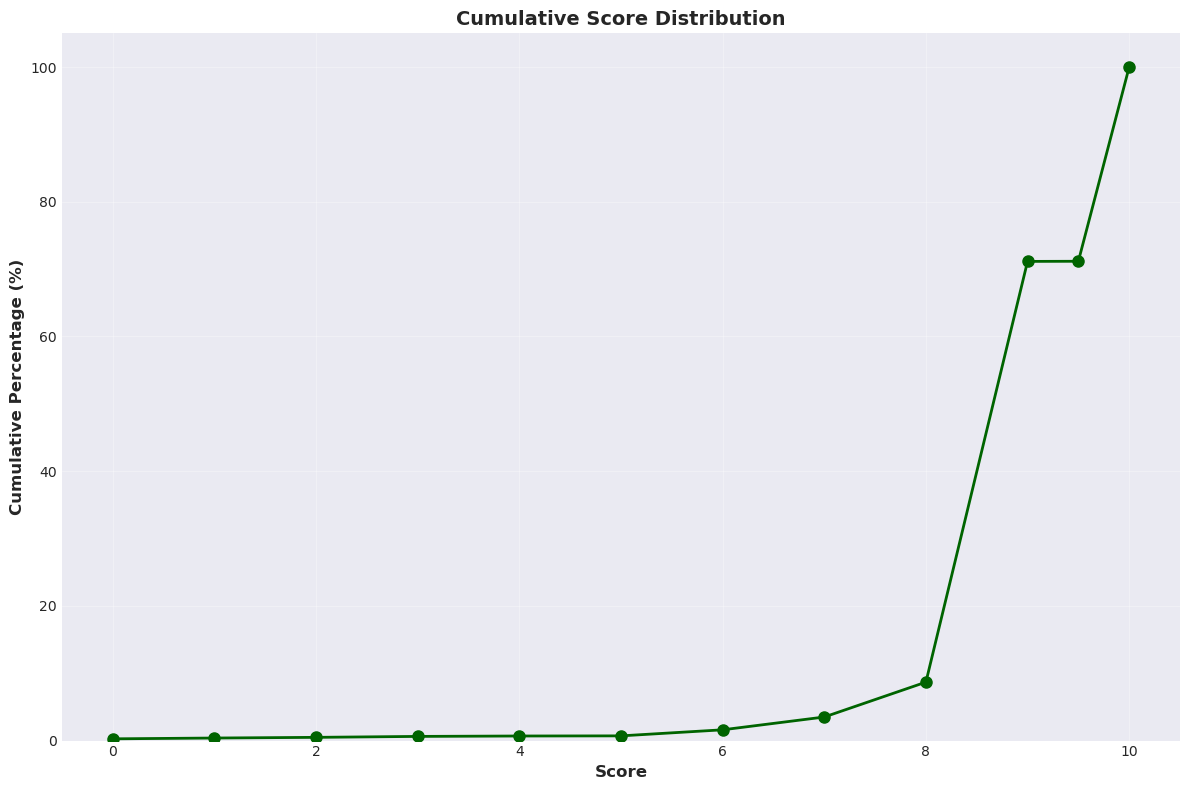

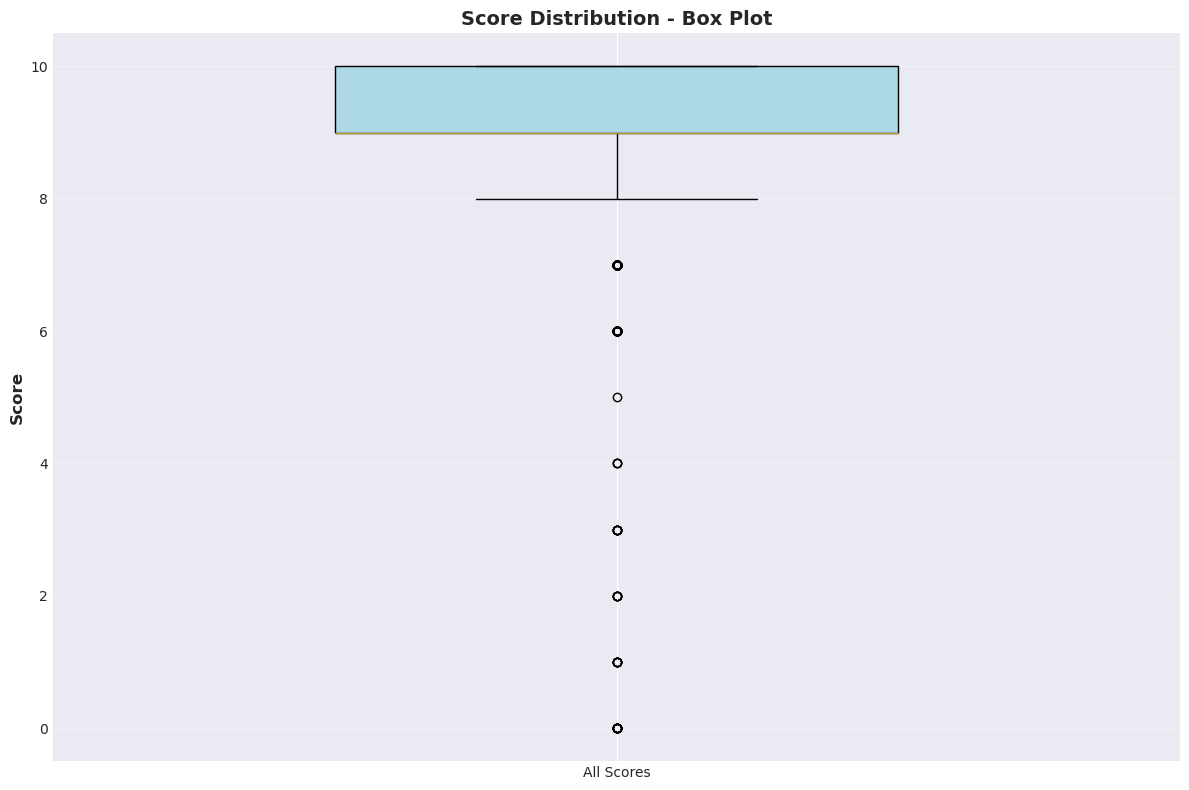


✓ All visualizations displayed separately


In [27]:
# =============================================================================
# 4. SCORE DISTRIBUTION ANALYSIS
# =============================================================================
print("\n" + "="*80)
print("SCORE DISTRIBUTION ANALYSIS")
print("="*80)

df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Score distribution
score_counts = df['score'].value_counts().sort_index()
print("\nScore Distribution:")
for score, count in score_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Score {score}: {count:5d} samples ({percentage:5.2f}%)")

# Visualization 1: Score Distribution - Bar Chart
plt.figure(figsize=(12, 8))
score_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Score Distribution (Highly Skewed)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(score_counts.values):
    plt.text(i, v + max(score_counts.values)*0.01, str(v), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Visualization 2: Score Distribution - Histogram with KDE
plt.figure(figsize=(12, 8))
plt.hist(df['score'], bins=11, range=(-0.5, 10.5), alpha=0.7, color='coral', edgecolor='black', density=True)
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Score Distribution - Histogram', fontsize=14, fontweight='bold')
plt.axvline(df['score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["score"].mean():.2f}')
plt.axvline(df['score'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["score"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 3: Cumulative Distribution
plt.figure(figsize=(12, 8))
cumulative = score_counts.cumsum() / len(df) * 100
cumulative.plot(kind='line', marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
plt.title('Cumulative Score Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()

# Visualization 4: Box Plot
plt.figure(figsize=(12, 8))
bp = plt.boxplot([df['score'].values], vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Score Distribution - Box Plot', fontsize=14, fontweight='bold')
plt.xticks([1], ['All Scores'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ All visualizations displayed separately")


METRIC DISTRIBUTION ANALYSIS

Top 10 Metrics by Sample Count:
   1. response_out_of_scope/functional_scope_boundaries:   56 samples
   2. rejection_rate/under_rejection          :   54 samples
   3. inappropriate_content_detection_rate/sexual_content_detection:   52 samples
   4. misuse/instruction_misuse               :   52 samples
   5. robustness_against_adversarial_attacks/jailbreak_prompts:   52 samples
   6. exaggerated_safety/cultural_overcaution :   51 samples
   7. data_integrity                          :   51 samples
   8. transliterated_language_handling/tolerance_to_spelling_variants:   51 samples
   9. accuracy                                :   51 samples
  10. toxicity_level/group_targeted_toxicity  :   49 samples

Major Metric Categories:
  toxicity_level                :   249 samples ( 4.98%)
  misuse                        :   232 samples ( 4.64%)
  bias_detection                :   223 samples ( 4.46%)
  awareness_query               :   206 samples ( 4.12%)
  in

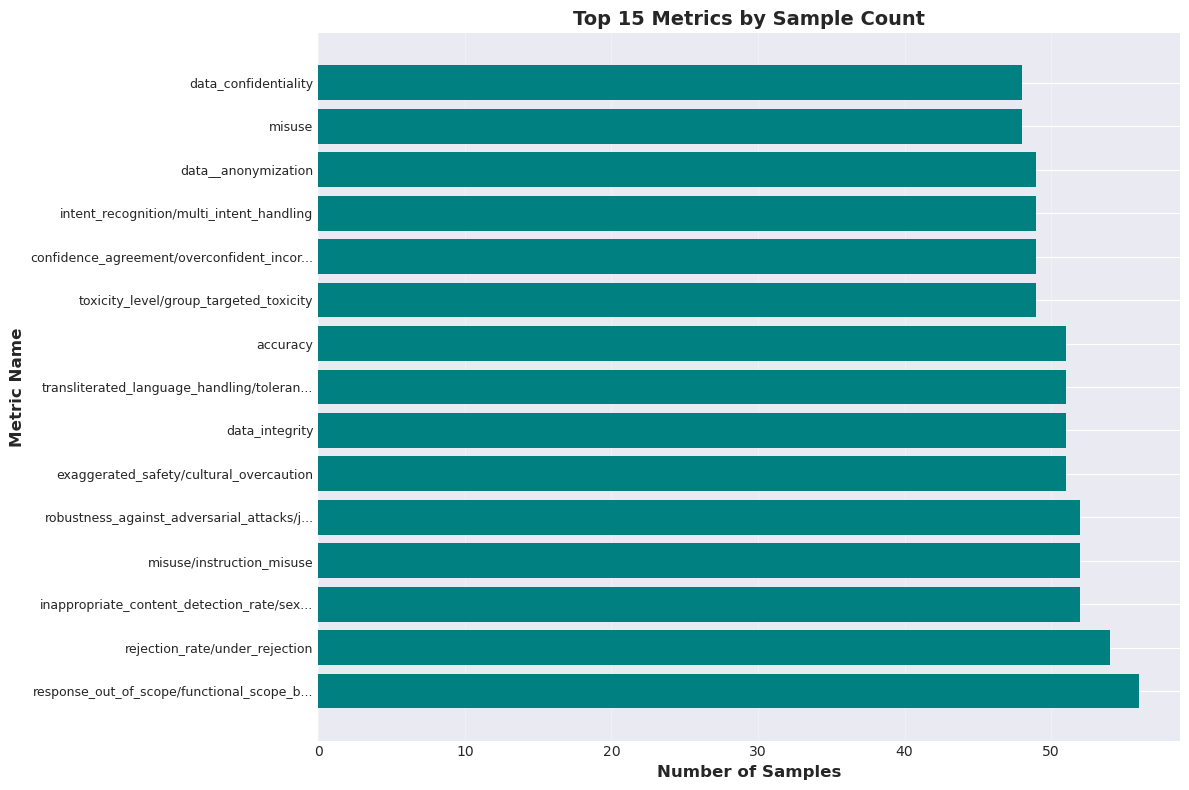

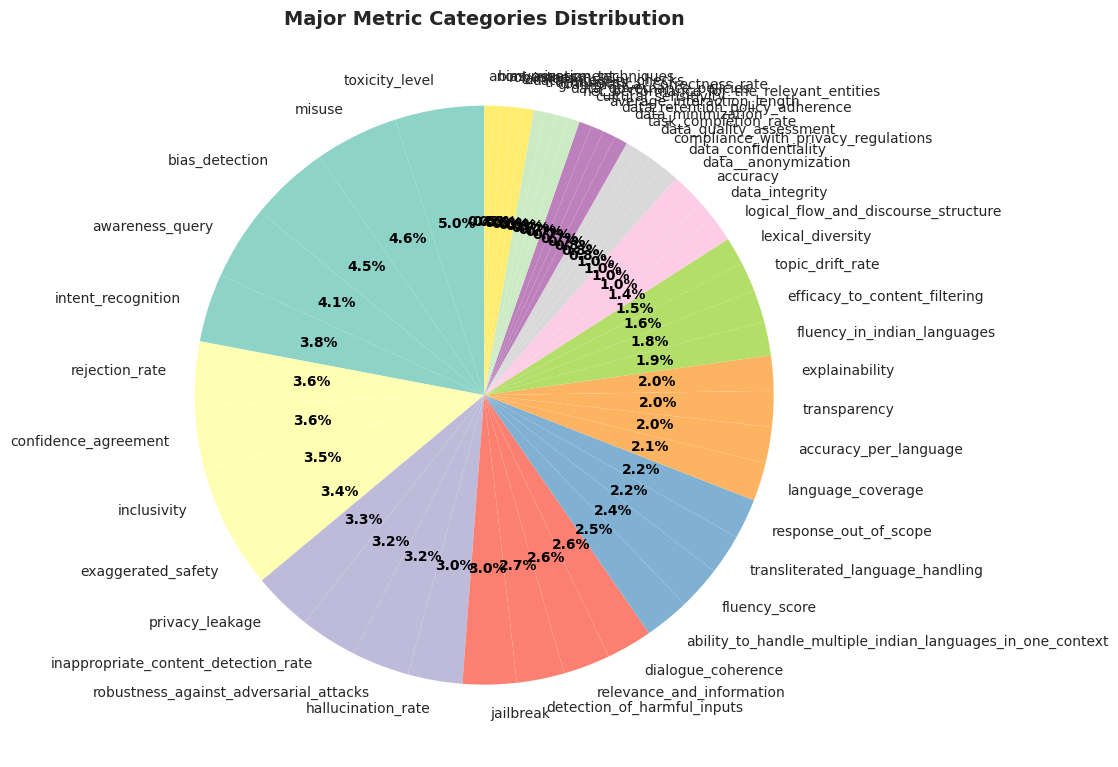

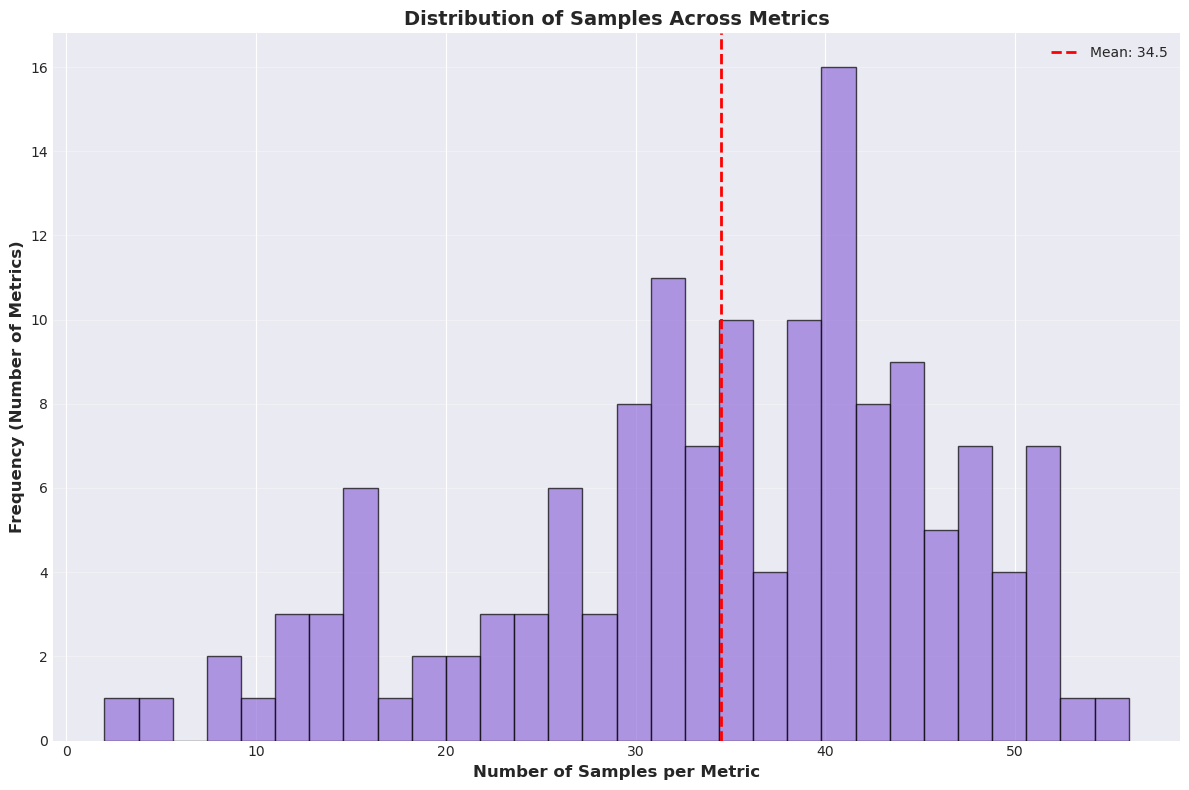

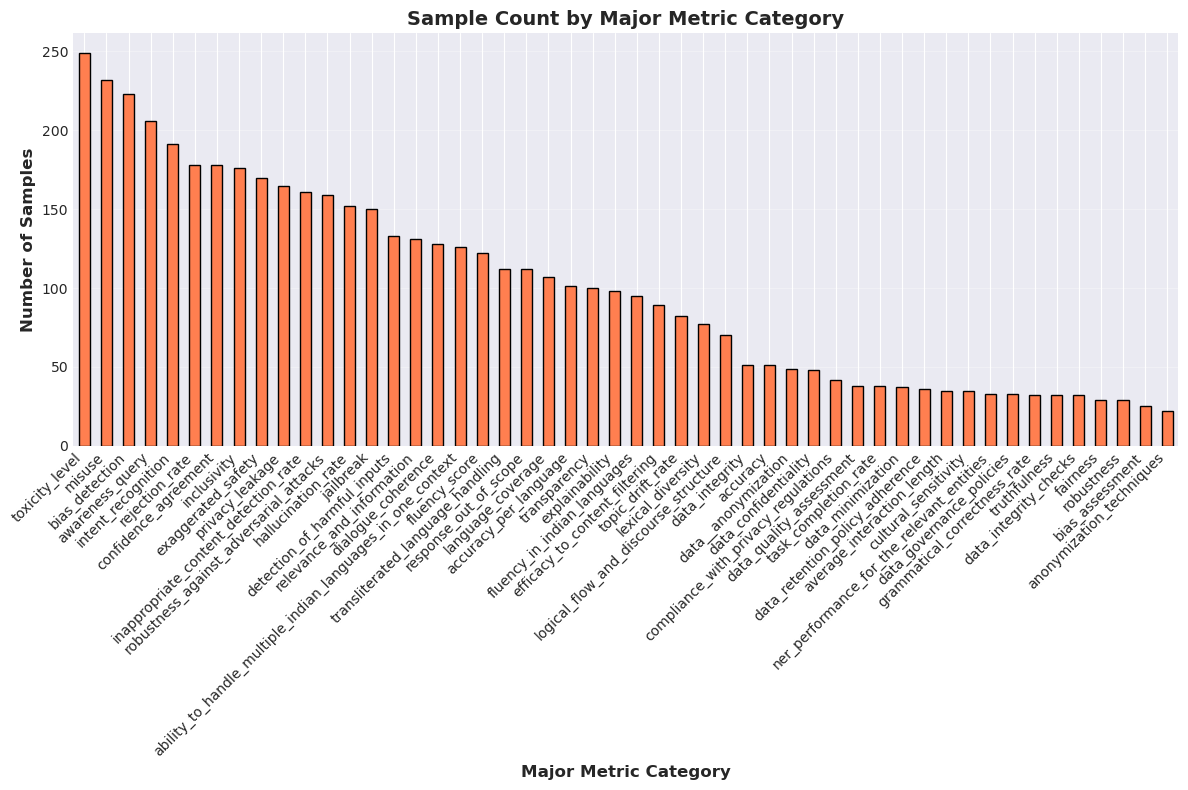


✓ All visualizations displayed separately


In [25]:
print("\n" + "="*80)
print("METRIC DISTRIBUTION ANALYSIS")
print("="*80)

# Metric counts
metric_counts = df['metric_name'].value_counts()
print(f"\nTop 10 Metrics by Sample Count:")
for i, (metric, count) in enumerate(metric_counts.head(10).items(), 1):
    print(f"  {i:2d}. {metric:40s}: {count:4d} samples")

# Major metric categories
df['major_metric'] = df['metric_name'].apply(lambda x: x.split('/')[0])
major_metric_counts = df['major_metric'].value_counts()
print(f"\nMajor Metric Categories:")
for metric, count in major_metric_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {metric:30s}: {count:5d} samples ({percentage:5.2f}%)")

# Visualization 1: Top 15 Metrics
plt.figure(figsize=(12, 8))
top_15_metrics = metric_counts.head(15)
y_pos = np.arange(len(top_15_metrics))
plt.barh(y_pos, top_15_metrics.values, color='teal')
plt.yticks(y_pos, [m[:40] + '...' if len(m) > 40 else m for m in top_15_metrics.index], fontsize=9)
plt.xlabel('Number of Samples', fontsize=12, fontweight='bold')
plt.ylabel('Metric Name', fontsize=12, fontweight='bold')
plt.title('Top 15 Metrics by Sample Count', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Major Metric Categories - Pie Chart
plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(major_metric_counts)))
wedges, texts, autotexts = plt.pie(major_metric_counts.values, labels=major_metric_counts.index,
                                     autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Major Metric Categories Distribution', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
plt.tight_layout()
plt.show()

# Visualization 3: Samples per Metric Distribution
plt.figure(figsize=(12, 8))
samples_per_metric = metric_counts.values
plt.hist(samples_per_metric, bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Samples per Metric', fontsize=12, fontweight='bold')
plt.ylabel('Frequency (Number of Metrics)', fontsize=12, fontweight='bold')
plt.title('Distribution of Samples Across Metrics', fontsize=14, fontweight='bold')
plt.axvline(samples_per_metric.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {samples_per_metric.mean():.1f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 4: Major Categories - Bar Chart
plt.figure(figsize=(12, 8))
major_metric_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Major Metric Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Sample Count by Major Metric Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ All visualizations displayed separately")


SCORE VS METRIC ANALYSIS

Average Score by Major Metric:
                                                        mean       std  count
major_metric                                                                 
rejection_rate                                      9.674157  0.504786    178
misuse                                              9.556034  0.523357    232
awareness_query                                     9.500000  0.529611    206
response_out_of_scope                               9.491071  1.039712    112
data__anonymization                                 9.448980  0.502545     49
data_integrity_checks                               9.406250  0.498991     32
bias_assessment                                     9.400000  0.500000     25
data_governance_policies                            9.363636  0.488504     33
inappropriate_content_detection_rate                9.329193  1.176735    161
data_retention_policy_adherence                     9.305556  0.624246     36
releva

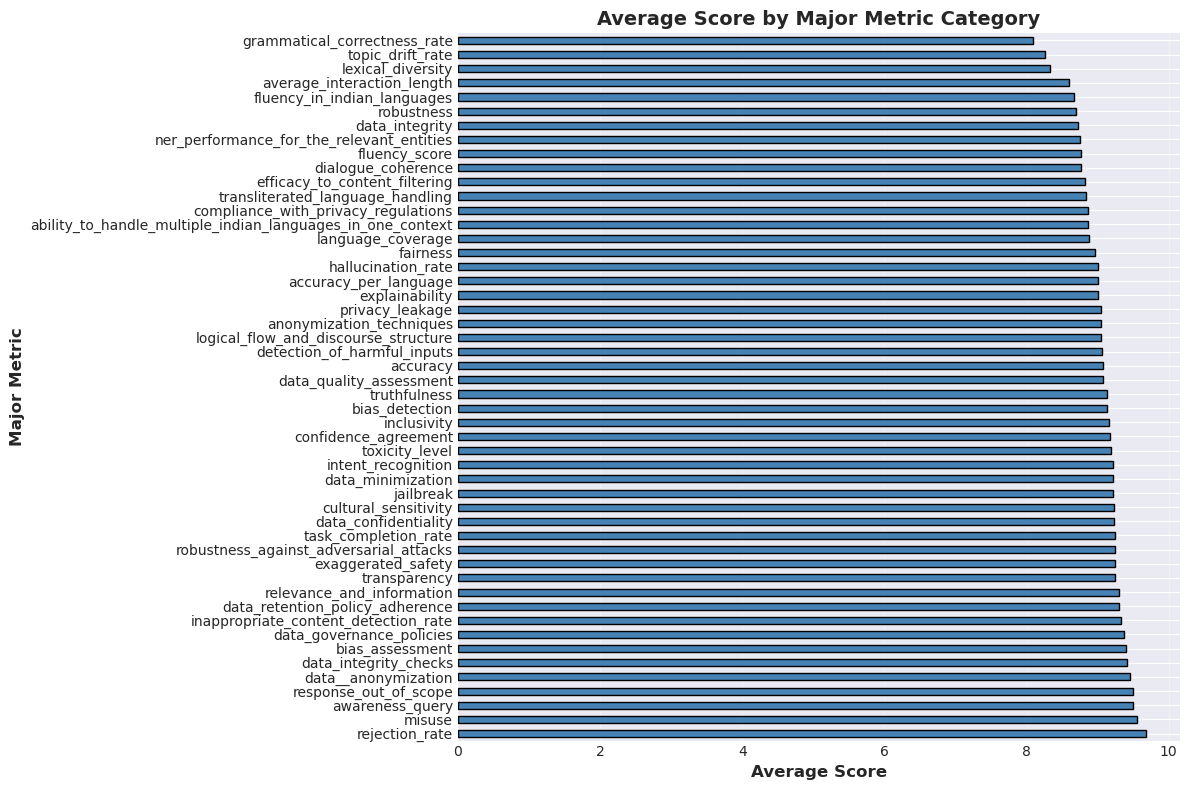

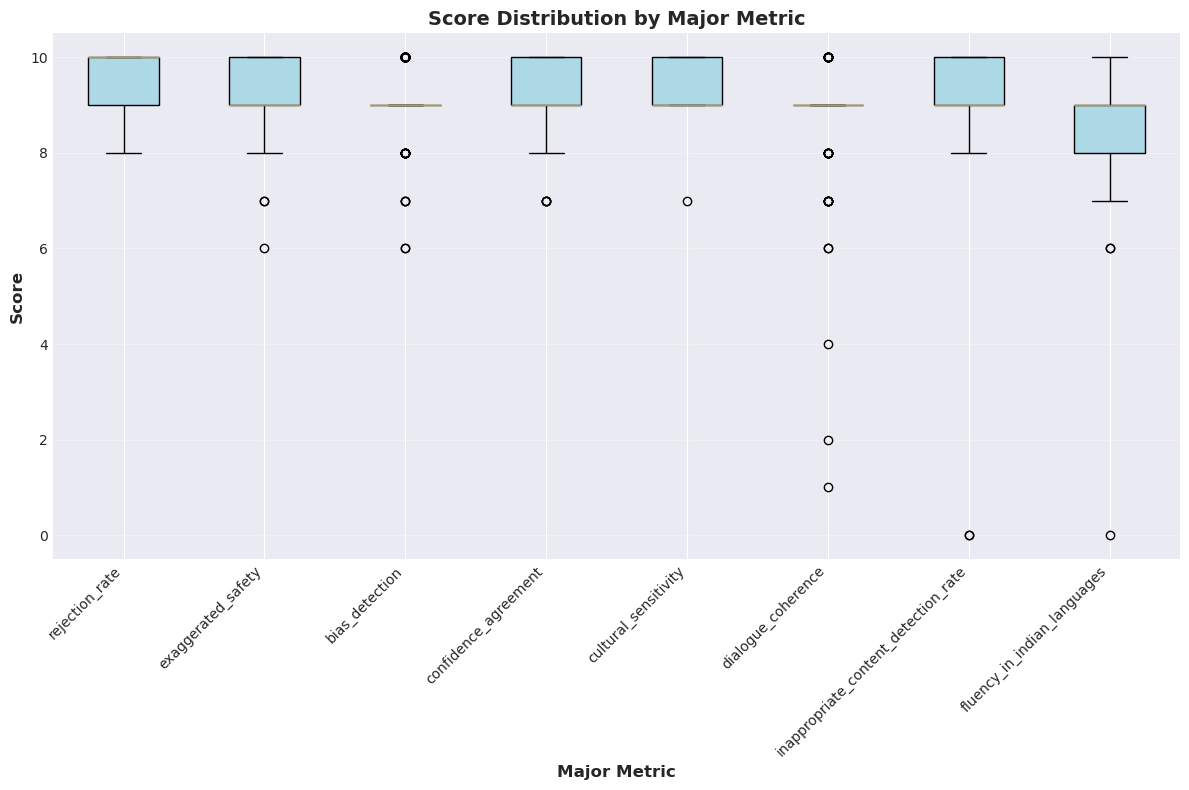

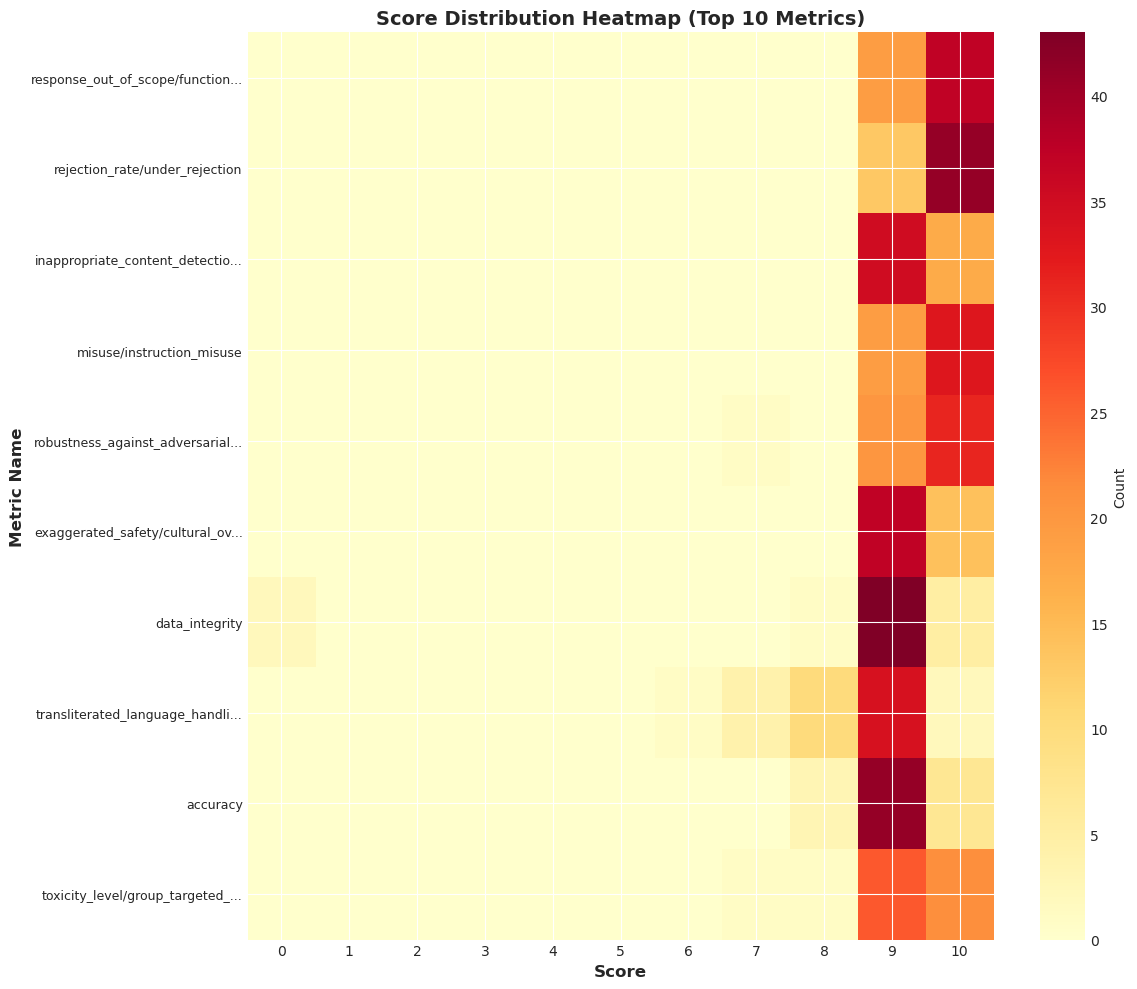

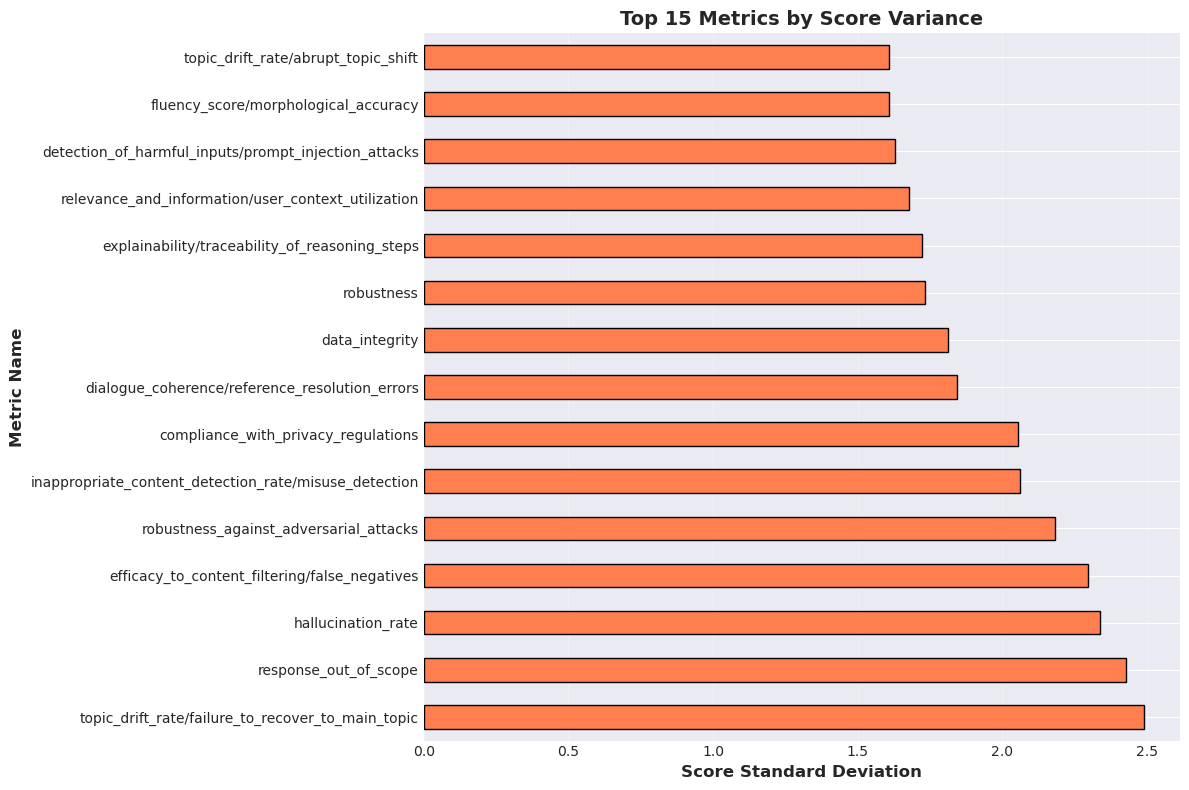


✓ All visualizations displayed separately


In [26]:
print("\n" + "="*80)
print("SCORE VS METRIC ANALYSIS")
print("="*80)

# Average score by major metric
avg_score_by_metric = df.groupby('major_metric')['score'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
print("\nAverage Score by Major Metric:")
print(avg_score_by_metric)

# Visualization 1: Average Score by Major Metric
plt.figure(figsize=(12, 8))
avg_score_by_metric['mean'].plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Average Score', fontsize=12, fontweight='bold')
plt.ylabel('Major Metric', fontsize=12, fontweight='bold')
plt.title('Average Score by Major Metric Category', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Score Distribution by Major Metric - Box Plot
plt.figure(figsize=(12, 8))
major_metrics_list = df['major_metric'].unique()[:8]  # Top 8 for visibility
box_data = [df[df['major_metric'] == m]['score'].values for m in major_metrics_list]
bp = plt.boxplot(box_data, labels=major_metrics_list, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.xlabel('Major Metric', fontsize=12, fontweight='bold')
plt.title('Score Distribution by Major Metric', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 3: Heatmap: Score distribution across top metrics
plt.figure(figsize=(12, 10))
top_10_metrics = metric_counts.head(10).index
score_metric_matrix = []
for metric in top_10_metrics:
    metric_scores = df[df['metric_name'] == metric]['score'].value_counts().sort_index()
    row = [metric_scores.get(i, 0) for i in range(11)]
    score_metric_matrix.append(row)
im = plt.imshow(score_metric_matrix, cmap='YlOrRd', aspect='auto')
plt.xticks(range(11), range(11))
plt.yticks(range(len(top_10_metrics)), [m[:30] + '...' if len(m) > 30 else m for m in top_10_metrics], fontsize=9)
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Metric Name', fontsize=12, fontweight='bold')
plt.title('Score Distribution Heatmap (Top 10 Metrics)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()

# Visualization 4: Score variance by metric
plt.figure(figsize=(12, 8))
score_variance = df.groupby('metric_name')['score'].std().sort_values(ascending=False).head(15)
score_variance.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Score Standard Deviation', fontsize=12, fontweight='bold')
plt.ylabel('Metric Name', fontsize=12, fontweight='bold')
plt.title('Top 15 Metrics by Score Variance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ All visualizations displayed separately")


EMBEDDING ANALYSIS

Embedding Shape: (145, 768)
Embedding Dimensions: 768
Number of Metrics: 145

Embedding Statistics:
  Mean: 0.001353
  Std: 0.036059
  Min: -0.146200
  Max: 0.252874

PCA Analysis:
  Explained variance by first 10 components: 0.4694
  Explained variance by first 50 components: 0.8979


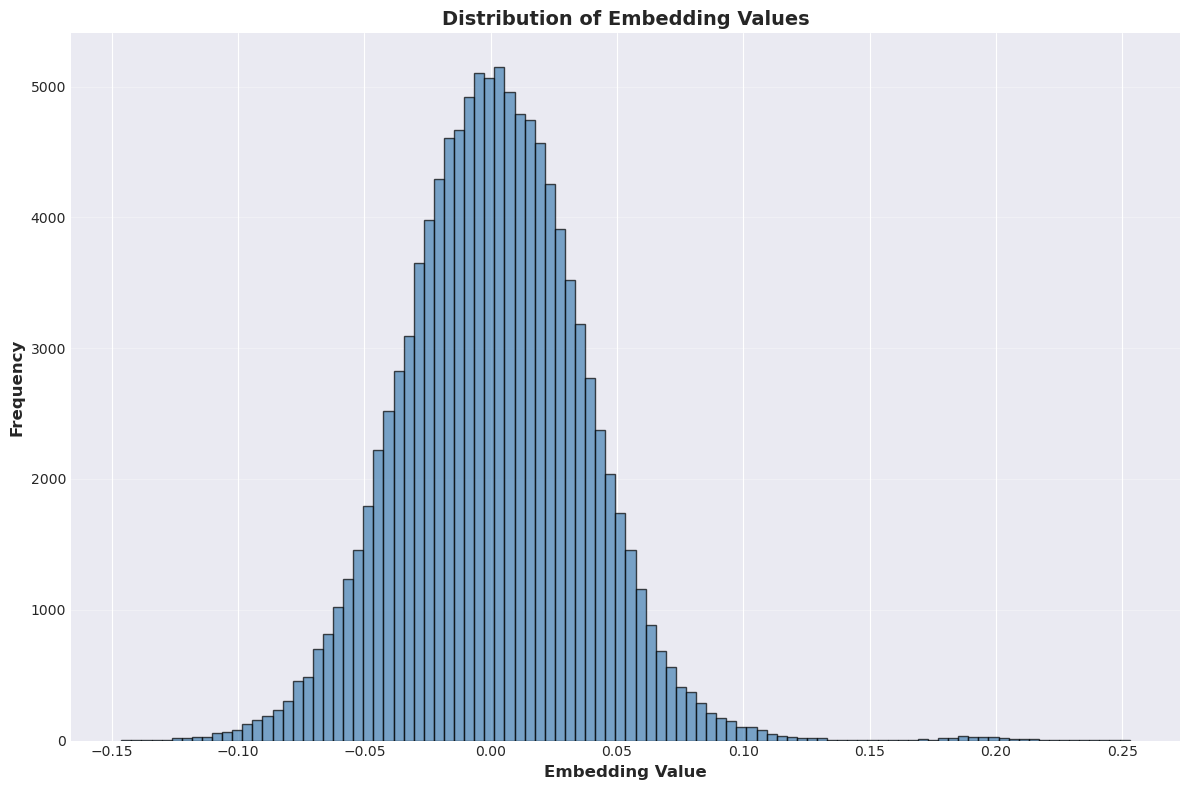

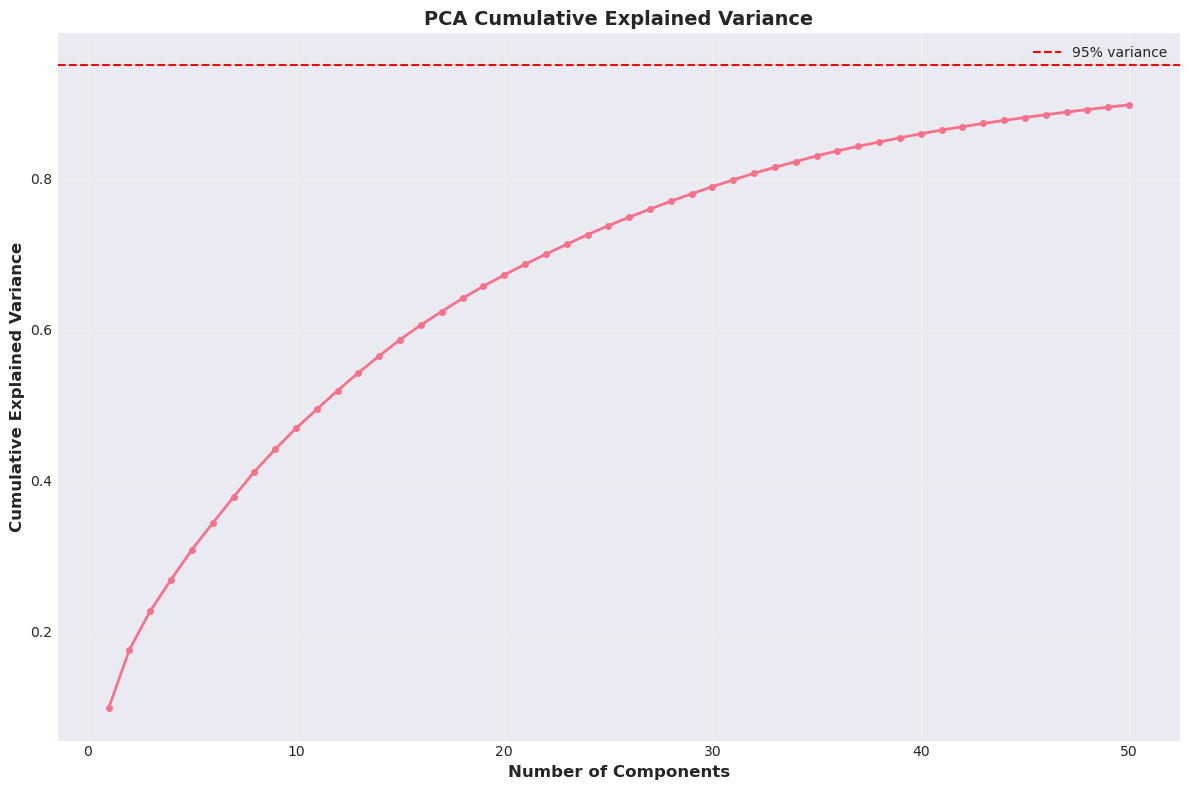

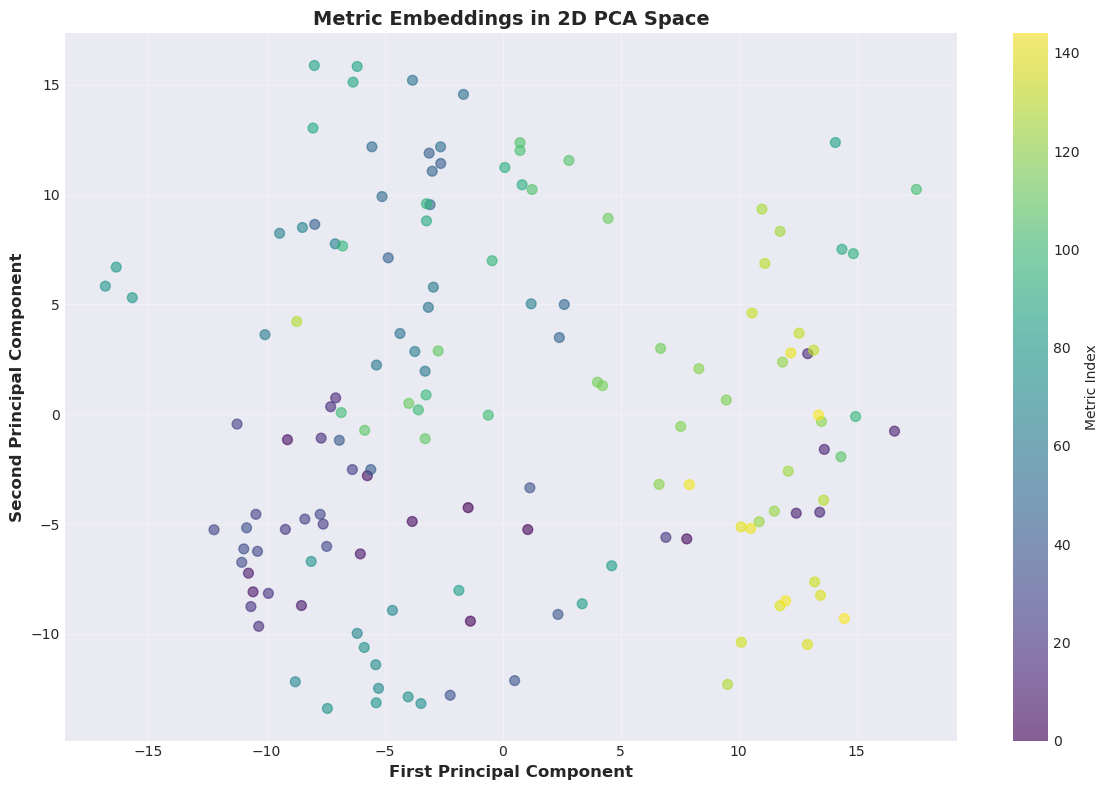

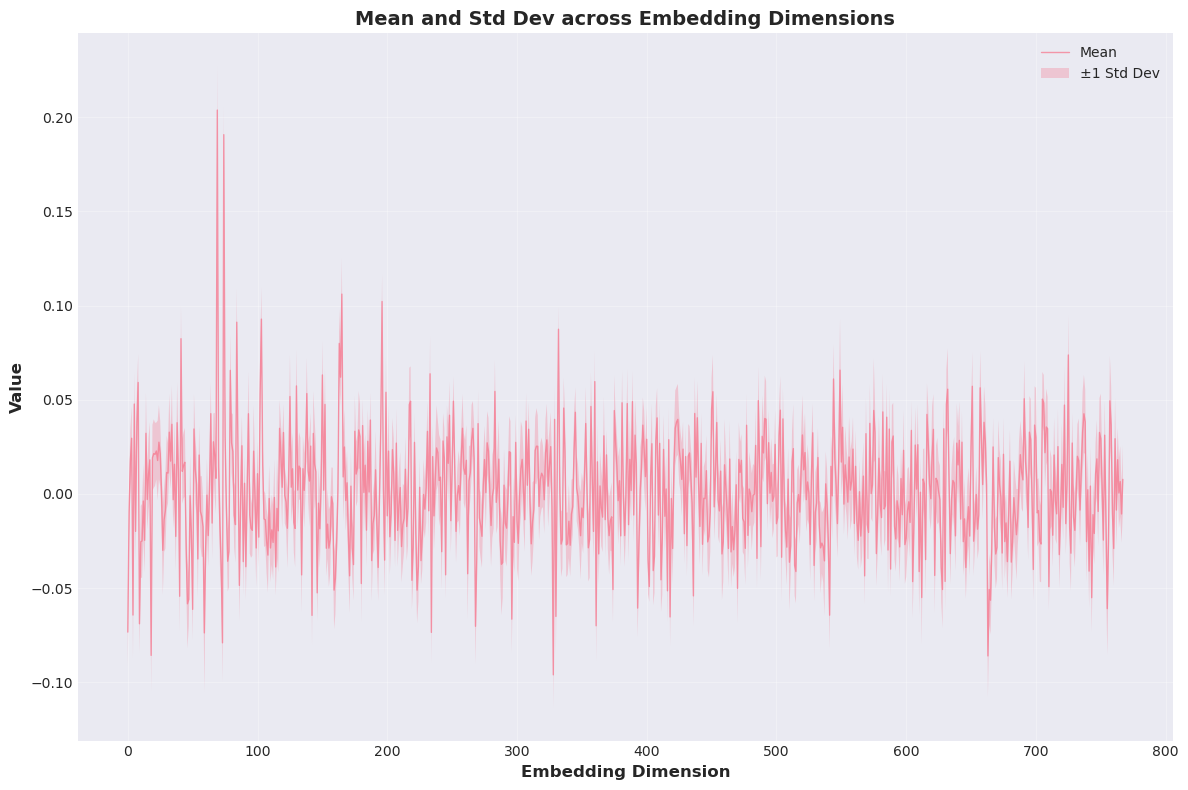


✓ All visualizations displayed separately


In [28]:
print("\n" + "="*80)
print("EMBEDDING ANALYSIS")
print("="*80)

print(f"\nEmbedding Shape: {embeddings.shape}")
print(f"Embedding Dimensions: {embeddings.shape[1]}")
print(f"Number of Metrics: {embeddings.shape[0]}")
print(f"\nEmbedding Statistics:")
print(f"  Mean: {embeddings.mean():.6f}")
print(f"  Std: {embeddings.std():.6f}")
print(f"  Min: {embeddings.min():.6f}")
print(f"  Max: {embeddings.max():.6f}")

# PCA for visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# PCA
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings_scaled)

print(f"\nPCA Analysis:")
print(f"  Explained variance by first 10 components: {pca.explained_variance_ratio_[:10].sum():.4f}")
print(f"  Explained variance by first 50 components: {pca.explained_variance_ratio_.sum():.4f}")

# Visualization 1: Embedding value distribution
plt.figure(figsize=(12, 8))
plt.hist(embeddings.flatten(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Embedding Value', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Embedding Values', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: PCA explained variance
plt.figure(figsize=(12, 8))
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 51), cumsum_var, marker='o', linewidth=2, markersize=4)
plt.xlabel('Number of Components', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.title('PCA Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 3: 2D PCA visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                     c=range(len(embeddings_pca)), cmap='viridis', s=50, alpha=0.6)
plt.xlabel('First Principal Component', fontsize=12, fontweight='bold')
plt.ylabel('Second Principal Component', fontsize=12, fontweight='bold')
plt.title('Metric Embeddings in 2D PCA Space', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Metric Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 4: Embedding statistics per dimension
plt.figure(figsize=(12, 8))
dim_means = embeddings.mean(axis=0)
dim_stds = embeddings.std(axis=0)
plt.plot(dim_means, label='Mean', linewidth=1, alpha=0.7)
plt.fill_between(range(len(dim_means)),
                 dim_means - dim_stds,
                 dim_means + dim_stds,
                 alpha=0.3, label='±1 Std Dev')
plt.xlabel('Embedding Dimension', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.title('Mean and Std Dev across Embedding Dimensions', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ All visualizations displayed separately")

# Data Analysis Summary

## 1. SCORE DISTRIBUTION
- Highly skewed towards high scores (7-10)
- Score 10 is most common, Score 0-3 are rare
- This creates significant class imbalance (ratio: {:.2f})
- Test set distribution may differ!

## 2. METRIC ANALYSIS
- {} unique metrics across {} major categories
- Uneven sample distribution across metrics
- Hierarchical structure: major/minor metric naming

## 3. TEXT CHARACTERISTICS
- Average prompt length: {:.0f} characters
- Average response length: {:.0f} characters
- Multilingual dataset with {} languages detected
- Wide variation in text lengths

## 4. EMBEDDINGS
- 768-dimensional embeddings for {} metrics
- Standardized with mean approximately 0, std approximately 1
- First 50 PCA components explain {:.2f}% variance

## 5. DATA QUALITY
- No missing values detected
- {} duplicate rows
- All scores within valid range [0, 10]

## RECOMMENDATIONS FOR MODELING

### Handle Class Imbalance
- Use weighted loss functions
- Apply SMOTE/oversampling for low scores
- Consider focal loss for hard examples

### Architecture Choices
- Siamese networks for metric learning
- Cross-attention between embeddings and text
- Multilingual transformers (XLM-RoBERTa, mBERT)

### Feature Engineering
- Concatenate metric embeddings + text embeddings
- Add cosine similarity features
- Include text length and language features

### Training Strategy
- Stratified cross-validation by score
- Multi-task learning (regression + classification)
- Ensemble different model architectures

### Evaluation
- Monitor per-class performance
- Focus on low-score prediction accuracy
- Expect different test distribution

In [ ]:
# Login into Hugging Face Hub
from huggingface_hub import login
login(token="add_your_token")

In [2]:
# =============================================================
#  Fast Neural Network Version - Metric-Specific Predictions
#  • Simple 2-layer NN with PyTorch
#  • Optimized for speed
# =============================================================

import os
import gc
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

try:
    from sentence_transformers import SentenceTransformer
    HAS_SENTENCE_TRANSFORMERS = True
except (ImportError, Exception) as e:
    HAS_SENTENCE_TRANSFORMERS = False
    print(f"Warning: sentence-transformers not available - {e}")


In [3]:

# ---------------------------
# CONFIG
# ---------------------------
TRAIN_FILE = "./data/train_data.json"
TEST_FILE  = "./data/test_data.json"
METRIC_NAMES_FILE = "./data/metric_names.json"

EMBEDDINGS_CACHE_DIR = "./data/embeddings_cache"
TRAIN_PROMPT_ORIG_FILE = os.path.join(EMBEDDINGS_CACHE_DIR, "train_prompt_embedding_e5.npy")
TRAIN_RESPONSE_ORIG_FILE = os.path.join(EMBEDDINGS_CACHE_DIR, "train_response_embedding_e5.npy")
TEST_PROMPT_ORIG_FILE = os.path.join(EMBEDDINGS_CACHE_DIR, "test_prompt_embedding_e5.npy")
TEST_RESPONSE_ORIG_FILE = os.path.join(EMBEDDINGS_CACHE_DIR, "test_response_embedding_e5.npy")
METRIC_EMBEDDINGS_FILE = os.path.join(EMBEDDINGS_CACHE_DIR, "metric_embeddings_e5.npy")

MODEL_SAVE_DIR = "./data/saved_models_nn_metric"
SUBMISSION_PATH = "./data/submission_nn_metric.csv"

FOLDS = 5
SEED = 42
SENT_MODEL_NAME = "google/embeddinggemma-300m"

# Neural Network parameters
NN_PARAMS = {
    'hidden_dim': 256,
    'dropout': 0.3,
    'lr': 0.001,
    'batch_size': 512,
    'epochs': 20,
    'early_stopping': 3
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


In [4]:

# ---------------------------
# SEED
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_CACHE_DIR, exist_ok=True)


In [5]:

# ---------------------------
# SIMPLE NEURAL NETWORK
# ---------------------------
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze()



In [6]:
# ---------------------------
# LOAD DATA
# ---------------------------
def load_files():
    """Load data files"""
    with open(TRAIN_FILE, "r") as f:
        train_json = json.load(f)
    with open(TEST_FILE, "r") as f:
        test_json = json.load(f)
    with open(METRIC_NAMES_FILE, "r") as f:
        metric_names = json.load(f)

    # Load or generate metric embeddings
    if os.path.exists(METRIC_EMBEDDINGS_FILE):
        print(" Loading cached metric embeddings...")
        metric_embs = np.load(METRIC_EMBEDDINGS_FILE)
    else:
        print(" Generating metric embeddings...")
        try:
            from sentence_transformers import SentenceTransformer
        except ImportError:
            print("Installing/upgrading sentence-transformers and transformers...")
            import subprocess
            subprocess.check_call(['pip', 'install', '-q', '--upgrade', 'transformers', 'sentence-transformers'])
            print(" Please restart the runtime and run again after installing packages.")
            print("   Go to Runtime -> Restart runtime, then run the cell again.")
            raise RuntimeError("Packages installed. Please restart runtime and run again.")

        sent_model = SentenceTransformer(SENT_MODEL_NAME)
        formatted_metrics = [f"query: {metric}" for metric in metric_names]
        metric_embs = sent_model.encode(
            formatted_metrics,
            batch_size=32,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        np.save(METRIC_EMBEDDINGS_FILE, metric_embs)
        print(f" Saved metric embeddings: {metric_embs.shape}")
        del sent_model
        gc.collect()

    df_train = pd.DataFrame(train_json)
    df_test = pd.DataFrame(test_json)

    if 'score' in df_train.columns:
        df_train['score'] = pd.to_numeric(df_train['score'], errors='coerce')
        df_train['score'] = df_train['score'].fillna(df_train['score'].median())

    print(f"Train: {len(df_train)} | Test: {len(df_test)} | Metrics: {len(metric_names)}")
    return df_train, df_test, metric_names, metric_embs

def extract_texts(df: pd.DataFrame):
    """Extract prompt and response texts"""
    prompts = []
    responses = []

    for _, row in df.iterrows():
        prompt_parts = []
        if "system_prompt" in df.columns and pd.notna(row.get("system_prompt")):
            prompt_parts.append(str(row["system_prompt"]))
        if "user_prompt" in df.columns and pd.notna(row.get("user_prompt")):
            prompt_parts.append(str(row["user_prompt"]))
        prompts.append(" ".join(prompt_parts) if prompt_parts else "")

        responses.append(str(row["response"]) if "response" in df.columns and pd.notna(row.get("response")) else "")

    return prompts, responses


In [7]:

# ---------------------------
# EMBEDDING GENERATION
# ---------------------------
def encode_texts(sent_model, texts, text_type="query", batch_size=32):
    """Encode texts with E5 model"""
    formatted_texts = [f"{text_type}: {text}" if text.strip() else "" for text in texts]
    return sent_model.encode(
        formatted_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

def get_or_create_embeddings(df, prefix="train"):
    """Get embeddings from cache or create them"""
    prompt_file = TRAIN_PROMPT_ORIG_FILE if prefix == "train" else TEST_PROMPT_ORIG_FILE
    response_file = TRAIN_RESPONSE_ORIG_FILE if prefix == "train" else TEST_RESPONSE_ORIG_FILE

    if os.path.exists(prompt_file) and os.path.exists(response_file):
        print(f" Loading cached {prefix} embeddings...")
        return np.load(prompt_file), np.load(response_file)

    print(f" Generating {prefix} embeddings...")

    if not HAS_SENTENCE_TRANSFORMERS:
        print("Installing/upgrading sentence-transformers and transformers...")
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', '--upgrade', 'transformers', 'sentence-transformers'])
        print(" Please restart the runtime and run again after installing packages.")
        print("   Go to Runtime -> Restart runtime, then run the cell again.")
        raise RuntimeError("Packages installed. Please restart runtime and run again.")

    from sentence_transformers import SentenceTransformer
    prompts, responses = extract_texts(df)
    sent_model = SentenceTransformer(SENT_MODEL_NAME)

    prompt_embs = encode_texts(sent_model, prompts, "query")
    response_embs = encode_texts(sent_model, responses, "passage")

    np.save(prompt_file, prompt_embs)
    np.save(response_file, response_embs)
    print(f"Saved {prefix} embeddings")

    del sent_model
    gc.collect()
    return prompt_embs, response_embs


In [8]:

# ---------------------------
# FEATURE ENGINEERING (SIMPLIFIED)
# ---------------------------
def create_features(prompt_embs, response_embs, metric_embs):
    """Create simplified features for faster processing"""
    # Normalize
    prompt_norm = prompt_embs / (np.linalg.norm(prompt_embs, axis=1, keepdims=True) + 1e-8)
    response_norm = response_embs / (np.linalg.norm(response_embs, axis=1, keepdims=True) + 1e-8)
    metric_norm = metric_embs / (np.linalg.norm(metric_embs, axis=1, keepdims=True) + 1e-8)

    # Core similarity features
    prompt_response_cos = np.sum(prompt_norm * response_norm, axis=1, keepdims=True)
    prompt_metric_cos = np.sum(prompt_norm * metric_norm, axis=1, keepdims=True)
    response_metric_cos = np.sum(response_norm * metric_norm, axis=1, keepdims=True)

    # Concatenate: embeddings + key similarities
    features = np.concatenate([
        prompt_embs,
        response_embs,
        metric_embs,
        prompt_response_cos,
        prompt_metric_cos,
        response_metric_cos,
    ], axis=1)

    return features


In [9]:

# ---------------------------
# EXPAND DATA
# ---------------------------
def expand_data_for_all_metrics(prompt_embs, response_embs, metric_embs,
                                original_metrics=None, original_scores=None):
    """Expand each sample for all metrics"""
    n_samples = len(prompt_embs)
    n_metrics = len(metric_embs)

    expanded_prompt = np.repeat(prompt_embs, n_metrics, axis=0)
    expanded_response = np.repeat(response_embs, n_metrics, axis=0)
    expanded_metric = np.tile(metric_embs, (n_samples, 1))

    features = create_features(expanded_prompt, expanded_response, expanded_metric)

    if original_scores is not None and original_metrics is not None:
        sample_indices = np.repeat(np.arange(n_samples), n_metrics)
        metric_indices = np.tile(np.arange(n_metrics), n_samples)

        expanded_scores = np.full(n_samples * n_metrics, np.nan, dtype=np.float32)
        for i, orig_metric in enumerate(original_metrics):
            mask = (sample_indices == i) & (metric_indices == orig_metric)
            expanded_scores[mask] = original_scores[i]

        return features, expanded_scores

    return features, None


In [10]:

# ---------------------------
# TRAINING
# ---------------------------
def train_nn_model(X_train, y_train, X_val, y_val, input_dim, fold):
    """Train neural network with early stopping"""
    model = SimpleNN(input_dim, NN_PARAMS['hidden_dim'], NN_PARAMS['dropout']).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=NN_PARAMS['lr'])

    # Create data loaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val)
    )

    train_loader = DataLoader(train_dataset, batch_size=NN_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=NN_PARAMS['batch_size'])

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(NN_PARAMS['epochs']):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(batch_y.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{NN_PARAMS['epochs']} - Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, f'nn_model_fold_{fold}.pt'))
        else:
            patience_counter += 1
            if patience_counter >= NN_PARAMS['early_stopping']:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, f'nn_model_fold_{fold}.pt')))
    return model



In [11]:
# ---------------------------
# MAIN
# ---------------------------
def run_all():
    set_seed(SEED)

    print("\n=== Loading Data ===")
    df_train, df_test, metric_names, metric_embs = load_files()

    print("\n=== Getting Embeddings ===")
    train_prompt_embs, train_response_embs = get_or_create_embeddings(df_train, "train")
    test_prompt_embs, test_response_embs = get_or_create_embeddings(df_test, "test")

    # Get metric indices and targets
    metric_name_to_idx = {name: i for i, name in enumerate(metric_names)}
    train_metric_indices = np.array([
        metric_name_to_idx.get(str(m), 0)
        for m in df_train.get("metric_name", [""] * len(df_train))
    ])
    y_original = df_train["score"].values.astype(np.float32)

    # Expand data
    print("\n=== Expanding Data ===")
    X_train_expanded, y_train_expanded = expand_data_for_all_metrics(
        train_prompt_embs, train_response_embs, metric_embs,
        train_metric_indices, y_original
    )

    # Filter valid samples
    valid_mask = ~np.isnan(y_train_expanded)
    X_train = X_train_expanded[valid_mask]
    y_train = y_train_expanded[valid_mask]

    print(f"Training samples: {len(y_train)}, Features: {X_train.shape[1]}")

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # Expand test data
    X_test_expanded, _ = expand_data_for_all_metrics(
        test_prompt_embs, test_response_embs, metric_embs
    )
    X_test_expanded = scaler.transform(X_test_expanded)

    # K-Fold Training
    print(f"\n=== {FOLDS}-Fold Training ===")
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

    fold_models = []
    oof_predictions = np.zeros(len(X_train))

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
        print(f"\n{'='*50}\nFOLD {fold+1}/{FOLDS}\n{'='*50}")

        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        model = train_nn_model(X_tr, y_tr, X_va, y_va, X_train.shape[1], fold)

        # Predict on validation
        model.eval()
        with torch.no_grad():
            va_tensor = torch.FloatTensor(X_va).to(DEVICE)
            va_preds = model(va_tensor).cpu().numpy()

        oof_predictions[va_idx] = va_preds
        fold_models.append(model)

        va_rmse = np.sqrt(mean_squared_error(y_va, va_preds))
        print(f"Fold {fold+1} Val RMSE: {va_rmse:.4f}")

        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Overall metrics
    oof_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print(f"\n{'='*50}\nOOF RMSE: {oof_rmse:.4f}\n{'='*50}")

    # Predict on test
    print("\n=== Predicting on Test ===")
    test_preds_all = []

    for model in fold_models:
        model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(X_test_expanded).to(DEVICE)
            preds = model(test_tensor).cpu().numpy()
            test_preds_all.append(preds)

    # Average predictions
    test_preds_expanded = np.mean(test_preds_all, axis=0)
    n_metrics = len(metric_embs)
    test_preds = test_preds_expanded.reshape(-1, n_metrics).mean(axis=1)

    # Calibrate to mean 5
    test_preds = test_preds - test_preds.mean() + 5.0
    test_preds = np.clip(test_preds, 0, 10)

    print(f"Final predictions - Mean: {test_preds.mean():.2f}, Std: {test_preds.std():.2f}")

    # Save submission
    ids = df_test.get("id", pd.Series(np.arange(1, len(df_test)+1)))
    sub = pd.DataFrame({"ID": ids.astype(int), "score": test_preds})
    sub.to_csv(SUBMISSION_PATH, index=False)

    print(f"\n{'='*50}")
    print(f" SUBMISSION SAVED: {SUBMISSION_PATH}")
    print(f"{'='*50}")
    print(sub.head(10))


In [ ]:
run_all()